<a href="https://colab.research.google.com/github/KravitzLab/PsygeneAnalyses/blob/main/Kravitz_PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FED3 PR1 analysis
<br>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQqe_1a1j1bQaqhOxq0VvukPqfolLRUqOdl-g&s" width="200" />

Updated: 10.13.25
Authored by Chantelle Murrell and Sebastian Alves



In [ ]:
# @title Install libraries and import them {"run":"auto"}

import importlib.util
import subprocess
import sys

# Packages to ensure are installed (add others here if you like)
packages = {
    "fed3": "git+https://github.com/earnestt1234/fed3.git",
    "fed3bandit": "fed3bandit",
    "pingouin": "pingouin",
    "ipydatagrid": "ipydatagrid",
    "openpyxl": "openpyxl",
}

for name, source in packages.items():
    if importlib.util.find_spec(name) is None:
        print(f"Installing {name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", source])

# ----------------------------
# Imports
# ----------------------------
# Standard library
import copy
import io
import math
import os
import re
import shutil
import tempfile
import threading
import time
import warnings
import zipfile
import glob
from datetime import datetime, timedelta
from os.path import basename, splitext

# Third-party
from ipydatagrid import DataGrid, TextRenderer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pingouin as pg
import fed3
import fed3.plot as fplot
import fed3bandit as f3b
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from google.colab import files
from tqdm.auto import tqdm
try:
    from google.colab import files as gfiles
except Exception:
    gfiles = None


# ----------------------------
# Configuration
# ----------------------------
warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12, 'figure.autolayout': True})
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

print("Packages installed and imports ready.")


Installing fed3...
Installing fed3bandit...
Installing pingouin...
Installing ipydatagrid...
Packages installed and imports ready.


In [ ]:
#@title Upload files

# Reset caches to avoid duplicates if you re-run this cell
feds, loaded_files, session_types = [], [], []

def extract_session_type(csv_path, fallback="Unknown"):
    """Read 'Session_Type ' or variants; return first non-empty value."""
    try:
        df = pd.read_csv(csv_path, sep=None, engine='python', dtype=str)
        df.columns = [c.strip() for c in df.columns]
        lower = {c.casefold(): c for c in df.columns}
        for cand in ["session_type", "session type", "sessiontype", "session"]:
            if cand in lower:
                col = lower[cand]
                vals = df[col].dropna().astype(str).str.strip()
                vals = vals[vals.ne("")]
                if not vals.empty:
                    return vals.iloc[0]
    except Exception:
        pass
    return fallback

uploaded = files.upload()

for name, data in uploaded.items():
    if name.lower().endswith(".zip"):
        with zipfile.ZipFile(io.BytesIO(data)) as zf:
            for zi in zf.infolist():
                if not zi.filename.lower().endswith(".csv"):
                    continue
                file_data = zf.read(zi)
                if len(file_data) <= 1024:
                    continue
                with tempfile.NamedTemporaryFile(mode="w+b", suffix=".csv", delete=False) as tmp:
                    tmp.write(file_data); tmp_path = tmp.name
                try:
                    session_type = extract_session_type(tmp_path)
                    df = fed3.load(tmp_path)
                    df.name = os.path.basename(zi.filename)
                    df.attrs = {"Session_type": session_type}
                    feds.append(df)
                    loaded_files.append(os.path.basename(zi.filename))
                    session_types.append(session_type)
                except Exception as e:
                    print(f"Error loading {zi.filename}: {e}")
                finally:
                    os.remove(tmp_path)
    elif name.lower().endswith(".csv"):
        if len(data) <= 1024:
            continue
        with tempfile.NamedTemporaryFile(mode="w+b", suffix=".csv", delete=False) as tmp:
            tmp.write(data); tmp_path = tmp.name
        try:
            session_type = extract_session_type(tmp_path)
            df = fed3.load(tmp_path)
            df.name = os.path.basename(name)
            df.attrs = {"Session_type": session_type}
            feds.append(df)
            loaded_files.append(os.path.basename(name))
            session_types.append(session_type)
        except Exception as e:
            print(f"Error loading {name}: {e}")
        finally:
            os.remove(tmp_path)

print(f"Loaded {len(loaded_files)} files. Session types captured for all.")
# Optional quick plot
if feds:
    try:
        fed3.as_aligned(feds, alignment="datetime", inplace=True)
        plt.figure(figsize=(8, 4))
        fplot.line(feds, y='pellets'); plt.legend().remove(); plt.tight_layout(); plt.show()
    except Exception as e:
        print(f"Plotting skipped: {e}")


In [ ]:
# @title Build Key_Df, Display & Edit


import os, glob, io
import numpy as np
import pandas as pd
from ipydatagrid import DataGrid, TextRenderer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from google.colab import files as colab_files
from google.colab import output as colab_output

# Require that the file-upload cell has already populated these:
assert 'loaded_files' in globals() and 'session_types' in globals(), \
    "Run the 'Upload FED3 files' cell first."

colab_output.enable_custom_widget_manager()

# ---------------------------
# Base: bare-bones Key_Df from loaded data
# ---------------------------
def _make_base_key_df():
    return pd.DataFrame({"filename": loaded_files, "Session_type": session_types})

def _file_base(s):
    return os.path.splitext(os.path.basename(str(s)))[0].strip()

def _norm_base_lower(s):
    return _file_base(s).lower()

# ---------------------------
# Key scanner: detect Mouse_ID or filename columns
# ---------------------------
def _scan_key_columns(df):
    """
    Returns dict:
      {
        'has_mouse': bool,
        'has_filename': bool,
        'filename_col': 'filename'|'File'|None,
        'msg': str
      }
    Accepts keys that have either Mouse_ID or a filename column (filename/File).
    """
    info = {'has_mouse': False, 'has_filename': False, 'filename_col': None, 'msg': ''}
    try:
        cols = [str(c).strip() for c in df.columns]
        has_mouse = 'Mouse_ID' in cols
        fname_col = 'filename' if 'filename' in cols else ('File' if 'File' in cols else None)
        info.update({
            'has_mouse': has_mouse,
            'has_filename': fname_col is not None,
            'filename_col': fname_col
        })
        if has_mouse:
            info['msg'] = "'Mouse_ID' found."
        elif fname_col:
            info['msg'] = f"'{fname_col}' found; will match on filename."
        else:
            info['msg'] = "Neither 'Mouse_ID' nor 'filename'/'File' found in provided key."
    except Exception as e:
        info['msg'] = f"Error while checking key: {e}"
    return info

# ---------------------------
# Read uploaded key (CSV/XLSX), accept Mouse_ID or filename
# ---------------------------
def _read_key_from_upload(name, content_bytes):
    """Return (df_or_None, message). Reads CSV/XLSX bytes from Colab upload."""
    ext = name.lower().rsplit('.', 1)[-1] if '.' in name else ''
    try:
        bio = io.BytesIO(content_bytes)
        if ext == 'xlsx':
            xls = pd.ExcelFile(bio, engine='openpyxl')
            frames = [pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names]
            key_df = pd.concat(frames, ignore_index=True, sort=False)
        elif ext == 'csv':
            key_df = pd.read_csv(bio, sep=None, engine='python')
        else:
            return None, f"Unsupported key type .{ext}"

        key_df = key_df.copy()
        key_df.columns = [str(c).strip() for c in key_df.columns]
        scan = _scan_key_columns(key_df)
        if not (scan['has_mouse'] or scan['has_filename']):
            return None, scan['msg']

        # Normalize types/columns we might use later
        if scan['has_mouse']:
            key_df['Mouse_ID'] = key_df['Mouse_ID'].astype(str).str.strip()

        if scan['has_filename']:
            fcol = scan['filename_col']
            key_df[fcol] = key_df[fcol].astype(str).str.strip()
            key_df['_key_file_base_lower'] = key_df[fcol].map(_norm_base_lower)

        # Persist a deterministic copy on disk for reproducibility
        fixed_path = f"_uploaded_key.{ext}"
        with open(fixed_path, "wb") as f:
            f.write(content_bytes)
        globals()['uploaded_key_path'] = fixed_path

        return key_df, f"Key loaded from upload ({name}) and saved to {fixed_path}. {scan['msg']}"
    except Exception as e:
        return None, f"Error reading uploaded key: {e}"

# ---------------------------
# Matching filename <-> Mouse_ID
# ---------------------------
def _match_mouse_id_to_filenames(filenames, key_df):
    """Return DataFrame: filename, Mouse_ID, match_status based on Mouse_ID substring in filename."""
    base_names_lower = [_norm_base_lower(f) for f in filenames]
    mouse_ids = (
        key_df['Mouse_ID']
        .dropna().astype(str).map(str.strip)
        .replace({'': np.nan}).dropna().unique().tolist()
    )
    rows = []
    for fname, base in zip(filenames, base_names_lower):
        hits = [mid for mid in mouse_ids if str(mid).lower() in base]
        if len(hits) == 1:
            rows.append({"filename": fname, "Mouse_ID": hits[0], "match_status": "Matched (Mouse_ID in filename)"})
        elif len(hits) > 1:
            longest = max(len(str(h)) for h in hits)
            best = [h for h in hits if len(str(h)) == longest]
            if len(best) == 1:
                rows.append({"filename": fname, "Mouse_ID": best[0], "match_status": "Matched (longest Mouse_ID token)"})
            else:
                rows.append({"filename": fname, "Mouse_ID": None, "match_status": f"Ambiguous Mouse_ID: {hits}"})
        else:
            rows.append({"filename": fname, "Mouse_ID": None, "match_status": "Mouse_ID not found in filename"})
    return pd.DataFrame(rows)

# ---------------------------
# Build/Rematch function
# ---------------------------
status_box = widgets.Output()
Key_Df = _make_base_key_df()  # start bare-bones

def build_or_rematch_key_df(key_df=None, msg_hint=""):
    """
    If key_df provided and valid:
      - Prefer Mouse_ID mapping if key has Mouse_ID.
      - Else fall back to filename merge (case-insensitive basename).
    Else: keep bare-bones.
    """
    global Key_Df
    files_df = _make_base_key_df().copy()
    files_df['_file_base_lower'] = files_df['filename'].map(_norm_base_lower)

    if key_df is None:
        Key_Df = files_df.drop(columns=['_file_base_lower']).copy()
        Key_Df["match_status"] = "No key"
        with status_box:
            clear_output(wait=True)
            print("Key status: No key provided; showing bare-bones Key_Df.")
        return

    # Identify key capabilities
    scan = _scan_key_columns(key_df)
    kd = key_df.copy()

    # Make a unique version of the key for whichever join we use
    def _dedup(df, subset_cols):
        dup_counts = df[subset_cols].astype(str).agg('|'.join, axis=1).value_counts()
        n_dups = int((dup_counts > 1).sum())
        if n_dups:
            with status_box:
                clear_output(wait=True)
                print(f"Note: {n_dups} duplicate key(s) on {subset_cols}; taking the first occurrence.")
        return df.drop_duplicates(subset=subset_cols, keep="first")

    if scan['has_mouse']:
        # Mouse_ID route (preferred)
        kd['Mouse_ID'] = kd['Mouse_ID'].astype(str).str.strip()
        key_unique = _dedup(kd, ['Mouse_ID'])

        matched = _match_mouse_id_to_filenames(files_df['filename'].tolist(), key_unique)[
            ["filename", "Mouse_ID", "match_status"]
        ]

        Key_Df = (
            files_df
            .merge(matched, on="filename", how="left")
            .merge(key_unique, on="Mouse_ID", how="left", suffixes=("", "_key"))
            .drop(columns=['_file_base_lower'])
        )

    elif scan['has_filename']:
        # Filename route (fallback)
        fcol = scan['filename_col']
        kd['_key_file_base_lower'] = kd[fcol].map(_norm_base_lower)
        key_unique = _dedup(kd, ['_key_file_base_lower'])

        Key_Df = (
            files_df
            .merge(key_unique, left_on="_file_base_lower", right_on="_key_file_base_lower", how="left", suffixes=("", "_key"))
            .drop(columns=['_file_base_lower', '_key_file_base_lower'])
        )
        # Give a simple match_status summary for filename matching
        Key_Df["match_status"] = np.where(
            Key_Df[fcol].notna(), "Matched (filename)", "Filename not found in key"
        )
    else:
        # Neither route available (shouldn't happen due to earlier check)
        Key_Df = files_df.drop(columns=['_file_base_lower']).copy()
        Key_Df["match_status"] = "Key missing Mouse_ID and filename columns"

    with status_box:
        clear_output(wait=True)
        if msg_hint:
            print(msg_hint)
        print(f"Merged key columns into Key_Df ({len(Key_Df)} rows, {len(Key_Df.columns)} cols).")

# ---------------------------
# Grid UI
# ---------------------------
def make_grid(df: pd.DataFrame):
    g = DataGrid(
        df,
        editable=True,
        selection_mode='cell',
        layout={'height': '420px'},
        base_row_size=28,
        base_column_size=120,
    )
    g.default_renderer = TextRenderer(text_wrap=True)
    return g

def rebuild_grid(msg=""):
    global grid, ui
    df = Key_Df.copy().reset_index(drop=True)
    new_grid = make_grid(df)
    ui.children = (upload_row, new_grid, controls, status_box)
    grid = new_grid
    with status_box:
        if msg:
            print(msg)
        print(f"Grid now shows Key_Df ({len(df)} rows, {len(df.columns)} cols)")

# ---------------------------
# Colab-native upload button ONLY (no path UI)
# ---------------------------
upload_btn = widgets.Button(description="Upload", button_style="primary", layout=widgets.Layout(width="120px"))
reset_btn = widgets.Button(description="Reset Key", button_style="warning", layout=widgets.Layout(width="120px"))
download_button = widgets.Button(description='Download', button_style='success', layout=widgets.Layout(width="120px"))

def on_colab_upload(_):
    with status_box:
        clear_output(wait=True)
        print("Opening Colab upload dialog...")
    uploaded = colab_files.upload()  # opens the native Colab picker
    if not uploaded:
        with status_box:
            print("No file selected.")
        return
    name, content = next(iter(uploaded.items()))
    key_df, msg = _read_key_from_upload(name, content)
    if key_df is None:
        build_or_rematch_key_df(None)
        rebuild_grid(f"Key status: {msg}")
    else:
        build_or_rematch_key_df(key_df, msg_hint=f"Key status: {msg}")
        rebuild_grid()

def _load_saved_key_from_disk():
    """Returns (key_df_or_None, message) from uploaded_key_path if present/valid."""
    key_path = globals().get('uploaded_key_path', None)
    if not (key_path and os.path.exists(key_path)):
        return None, "No saved key on disk to reload."
    try:
        ext = key_path.lower().rsplit('.', 1)[-1] if '.' in key_path else ''
        if ext == 'xlsx':
            xls = pd.ExcelFile(key_path, engine='openpyxl')
            frames = [pd.read_excel(xls, sheet_name=s) for s in xls.sheet_names]
            key_df = pd.concat(frames, ignore_index=True, sort=False)
        elif ext == 'csv':
            key_df = pd.read_csv(key_path, sep=None, engine='python')
        else:
            return None, f"Unsupported key type .{ext}"

        key_df = key_df.copy()
        key_df.columns = [str(c).strip() for c in key_df.columns]
        scan = _scan_key_columns(key_df)
        if not (scan['has_mouse'] or scan['has_filename']):
            return None, scan['msg']

        if scan['has_mouse']:
            key_df['Mouse_ID'] = key_df['Mouse_ID'].astype(str).str.strip()
        if scan['has_filename']:
            fcol = scan['filename_col']
            key_df[fcol] = key_df[fcol].astype(str).str.strip()
            key_df['_key_file_base_lower'] = key_df[fcol].map(_norm_base_lower)

        return key_df, f"Key reloaded from {os.path.basename(key_path)}. {scan['msg']}"
    except Exception as e:
        return None, f"Error reading saved uploaded key: {e}"

def on_reset(_):
    """
    Reset now auto-rematches using the last uploaded key if available.
    If no saved key exists or it's invalid, we fall back to bare-bones.
    """
    key_df, msg = _load_saved_key_from_disk()
    if key_df is None:
        build_or_rematch_key_df(None)
        rebuild_grid(f"Key status: {msg} (showing bare-bones Key_Df).")
    else:
        build_or_rematch_key_df(key_df, msg_hint=f"Key status: {msg}")
        rebuild_grid("Reset: reloaded saved key and rematched.")

def download_df(_):
    global Key_Df
    with status_box:
        clear_output(wait=True)
        print("Saving latest Key_Df as XLSX ...")
    try:
        path = "/content/Key_Df.xlsx"
        Key_Df.to_excel(path, index=False, engine='openpyxl')
        colab_files.download(path)
        with status_box:
            clear_output(wait=True)
            print("Saved and downloading Key_Df.xlsx ...")
    except Exception as e:
        with status_box:
            clear_output(wait=True)
            print(f"Error while saving/downloading: {e}")

upload_btn.on_click(on_colab_upload)
reset_btn.on_click(on_reset)
download_button.on_click(download_df)

upload_row = widgets.HBox([
    widgets.HTML("<b>Optional key:</b>"),
    upload_btn,
    reset_btn,
    download_button
])

# ---------------------------
# Edit / rematch / download controls
# ---------------------------
new_col_name    = widgets.Text(placeholder='Enter new column name', description='New Col:')
add_col_button  = widgets.Button(description='Add Column', button_style='info')
apply_button    = widgets.Button(description='Apply Changes', button_style='primary', layout=widgets.Layout(width="120px"))

def add_column(_):
    global Key_Df
    col = new_col_name.value.strip()
    with status_box:
        clear_output(wait=True)
        if not col:
            print("Please enter a column name."); return
        if col in Key_Df.columns:
            print(f"Column '{col}' already exists."); return
        Key_Df[col] = ""
        print(f"Added column '{col}' to Key_Df.")
    rebuild_grid()

def apply_edits(_):
    global Key_Df
    try:
        Key_Df = grid.data.copy().reset_index(drop=True)
        with status_box:
            clear_output(wait=True)
            print(f"Applied grid edits to Key_Df ({len(Key_Df)} rows, {len(Key_Df.columns)} cols).")
    except Exception as e:
        with status_box:
            clear_output(wait=True)
            print(f"Error applying edits: {e}")

add_col_button.on_click(add_column)
apply_button.on_click(apply_edits)

controls = widgets.HBox([new_col_name, add_col_button, apply_button])

# ---------------------------
# Initialize UI
# ---------------------------
Key_Df = _make_base_key_df()
Key_Df["match_status"] = "No key"

grid = make_grid(Key_Df.copy().reset_index(drop=True))
ui = widgets.VBox([upload_row, grid, controls, status_box])
display(ui)

In [ ]:
# @title Individual plots

assert 'Key_Df' in globals() and isinstance(Key_Df, pd.DataFrame), "Build/rematch Key_Df first."

# metadata_df = copy of Key_Df
metadata_df = Key_Df.copy().reset_index(drop=True)
if 'filename' in metadata_df.columns:
    metadata_df['filename'] = metadata_df['filename'].astype(str).map(os.path.basename)

# -------- Plotting Function --------
def plot_file(file_index):
    """
    Returns (fig, filename) for UI to display/save.
    Prints a message and returns (None, None) on errors.
    """
    # Safety check
    if 'feds' not in globals() or file_index >= len(feds):
        print(f"Index {file_index} is out of range (max {len(feds)-1 if 'feds' in globals() else 'N/A'}).")
        return None, None

    df = feds[file_index]
    # Keep only pellet rows, but don't mutate df
    pellet_df = df[df['Event'] == 'Pellet'].copy()
    if pellet_df.empty:
        print(f"No pellet events for file index {file_index}.")
        return None, None

    # Determine filename for title/return
    if 'loaded_files' in globals() and len(loaded_files) > file_index:
        raw_file = loaded_files[file_index]
    elif 'files' in globals() and len(files) > file_index:
        raw_file = files[file_index]
    else:
        raw_file = f"file_{file_index}"
    filename = os.path.basename(str(raw_file))

    # Match Mouse_ID from metadata, robust to path vs basename
    title_str = filename
    if 'filename' in metadata_df.columns:
        md_fn = metadata_df['filename'].astype(str).map(os.path.basename)
        hit = metadata_df.loc[md_fn == filename]
        if not hit.empty:
            match_row = hit.iloc[0]
            if 'Mouse_ID' in match_row and pd.notna(match_row['Mouse_ID']):
                title_str = f"{match_row['Mouse_ID']}"

    # Determine x-axis
    x_series = None
    x_is_datetime = isinstance(pellet_df.index, pd.DatetimeIndex)
    if x_is_datetime:
        x_series = pellet_df.index
    else:
        for col in ['Timestamp', 'Time', 'DateTime', 'Datetime', 'datetime']:
            if col in pellet_df.columns:
                ts = pd.to_datetime(pellet_df[col], errors='coerce')
                if ts.notna().any():
                    pellet_df['_x'] = ts
                    x_series = pellet_df['_x']
                    x_is_datetime = True
                    break
        if x_series is None:
            x_series = pellet_df.index  # fall back to index

    # Build figure (DO NOT show here)
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)

    hue_vals = pellet_df['Block_Pellet_Count'].clip(upper=40)
    sns.scatterplot(
        data=pellet_df,
        x=x_series,
        y='Block_Pellet_Count',
        hue=hue_vals,
        palette='spring',
        alpha=0.6,
        legend=False,
        ax=ax
    )

    # Night shading if datetime x
    if x_is_datetime:
        import datetime as dt
        night_start = dt.time(18, 0)  # 18:00
        night_end   = dt.time(6, 0)   # 06:00

        start_date = pd.to_datetime(pd.Series(x_series)).min().normalize()
        end_date   = pd.to_datetime(pd.Series(x_series)).max().normalize()

        # shade from each day's 18:00 to next day's 06:00
        for day in pd.date_range(start_date, end_date - pd.Timedelta(days=1)):
            start = pd.Timestamp.combine(day, night_start)
            end   = pd.Timestamp.combine(day + pd.Timedelta(days=1), night_end)
            ax.axvspan(start, end, color='gray', alpha=0.2)

        import matplotlib.dates as mdates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.set_xlabel('')
    else:
        ax.set_xlabel('Index')
    ax.set_ylabel('Pellet Count in Block')
    ax.set_title(title_str)
    fig.tight_layout()

    # Return for UI to display/save later
    return fig, filename

# ---------- UI: single instance ----------
demand_ui = {}

def _sanitize_filename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)

# Slider bounds from number of feds (not files)
n_items = len(feds) if 'feds' in globals() else 1
slider = widgets.IntSlider(
    min=0, max=max(0, n_items-1), step=1, value=0,
    description="File", continuous_update=True
)
save_btn = widgets.Button(description="Save PDF")
status = widgets.HTML()
out = widgets.Output()

def _update_plot(change=None):
    with out:
        out.clear_output(wait=True)
        fig, file = plot_file(slider.value)
        if fig is None:
            status.value = "<span style='color:#b00'>No figure to display.</span>"
            return
        display(fig)      # show exactly one figure
        plt.close(fig)    # close backend handle to prevent accumulation
        demand_ui["_last_fig"] = fig
        demand_ui["_last_file"] = file
        status.value = "" # clear old status

def _save_pdf(_):
    fig = demand_ui.get("_last_fig")
    file = demand_ui.get("_last_file", "figure")
    if fig is None:
        status.value = "<span style='color:#b00'>No figure to save.</span>"
        return
    base = _sanitize_filename(os.path.splitext(os.path.basename(str(file)))[0])
    fname = f"demand_{base}_{datetime.now():%Y%m%d_%H%M%S}.pdf"
    fig.savefig(fname, format="pdf", bbox_inches="tight")
    if 'gfiles' in globals() and gfiles is not None:
        status.value = f"Preparing download: <code>{fname}</code>…"
        try:
            gfiles.download(fname)
        except Exception as e:
            status.value = f"Saved locally at <code>{os.path.abspath(fname)}</code> (download helper failed: {e})."
    else:
        status.value = f"Saved locally at <code>{os.path.abspath(fname)}</code>."

slider.observe(_update_plot, names="value")
save_btn.on_click(_save_pdf)

# Keep references so we can close them next run
box = widgets.HBox([slider, save_btn])
demand_ui.update({"slider": slider, "save_btn": save_btn, "status": status, "out": out, "box": box})

# Display the controls and initial plot
display(box, status, out)
_update_plot()


In [ ]:
# @title Analyse PR metrics
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
try:
    from tqdm.auto import tqdm as _tqdm
except Exception:
    try:
        # If user did `from tqdm import tqdm` earlier
        _tqdm = tqdm  # type: ignore[name-defined]
    except Exception:
        # Fallback: no-op iterator
        def _tqdm(x, **kwargs):
            return x
# --- Preconditions ---
assert 'metadata_df' in globals() and isinstance(metadata_df, pd.DataFrame), \
    "metadata_df not found. Build/rematch Key_Df and set metadata_df = Key_Df.copy() first."
assert 'feds' in globals() and isinstance(feds, (list, tuple)) and len(feds) > 0, \
    "No FED3 sessions found. Expecting a non-empty 'feds' list."

# ---------- Small helpers (merged + minimal PR utilities) ----------
def _basename(pathlike) -> str:
    s = str(pathlike).replace("\\", "/")
    return s.split("/")[-1]

def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def _count_events(df, label: str) -> int:
    if "Event" not in df.columns:
        return 0
    return int((df["Event"].astype(str) == label).sum())

def breakpoint_and_runs(df):
    """
    Merge of _breakpoint_stats(df) and _count_runs(df).
    Returns: (median_breakpoint, max_breakpoint, runs_count)
    - 'Breakpoint' is taken at the end of a block/run: current BPC > 0 and next BPC == 0
    - 'runs_count' is the number of such end-of-block events
    """
    if "Block_Pellet_Count" not in df.columns or df["Block_Pellet_Count"].empty:
        return np.nan, np.nan, 0

    bpc = _to_num(df["Block_Pellet_Count"])
    # end-of-block: positive now, zero next
    end_mask = (bpc > 0) & (bpc.shift(-1) == 0)
    end_vals = bpc[end_mask]

    med_bp = float(end_vals.median()) if len(end_vals) else np.nan
    max_bp = float(bpc.max()) if bpc.notna().any() else np.nan
    runs   = int(end_mask.sum())
    return med_bp, max_bp, runs

def _get_timestamp_series(df, ts_col="MM:DD:YYYY hh:mm:ss"):
    """Return a pandas Series of timestamps (never an Index)."""
    if ts_col in df.columns:
        ts = pd.to_datetime(df[ts_col], format="%Y-%m-%d %H:%M:%S", errors="coerce")
        return pd.Series(ts, index=df.index)
    for cand in ["DateTime", "Datetime", "Timestamp", "timestamp", "datetime"]:
        if cand in df.columns:
            ts = pd.to_datetime(df[cand], errors="coerce")
            return pd.Series(ts, index=df.index)
    idx = df.index
    if isinstance(idx, pd.DatetimeIndex):
        return pd.Series(idx, index=df.index)
    return pd.to_datetime(pd.Series(idx, index=df.index), errors="coerce")

def _estimate_daily_pellets(df):
    ts = _get_timestamp_series(df)
    valid_ts = ts.dropna()
    if valid_ts.size < 2:
        return np.nan
    duration_hours = (valid_ts.max() - valid_ts.min()).total_seconds() / 3600.0
    if duration_hours <= 0:
        return np.nan

    pellet_events = np.nan
    if "Pellet_Count" in df.columns and df["Pellet_Count"].notna().any():
        pc = pd.to_numeric(df["Pellet_Count"], errors="coerce")
        if pc.notna().any():
            diffs = pc.diff().fillna(0).clip(lower=0)
            pellet_events = float(diffs.sum())
            if pellet_events == 0 and pc.iloc[-1] >= pc.iloc[0]:
                pellet_events = float(pc.iloc[-1] - pc.iloc[0])

    if (pd.isna(pellet_events)) and ("Event" in df.columns):
        pellet_events = float((df["Event"].astype(str) == "Pellet").sum())

    if pd.isna(pellet_events):
        return np.nan
    return (pellet_events / duration_hours) * 24.0

# ---------- Step 4: normalize metadata_df ----------
md = metadata_df.copy()
# Normalize filename column to basename; accept either 'filename' or 'File'
if 'filename' in md.columns:
    md['filename'] = md['filename'].astype(str).map(_basename)
elif 'File' in md.columns:
    md['filename'] = md['File'].astype(str).map(_basename)
else:
    raise ValueError("metadata_df must contain a 'filename' or 'File' column.")

# Ensure Mouse_ID exists and is a clean string column
if 'Mouse_ID' in md.columns:
    md['Mouse_ID'] = md['Mouse_ID'].astype(str).str.strip()
else:
    md['Mouse_ID'] = np.nan

# ---------- Step 5: compute PR metrics for ALL files ----------
rows = []
for idx, c_df in enumerate(_tqdm(feds, desc="Computing PR metrics")):
    # Prefer DataFrame.name if present; otherwise synthesize a filename
    file_name = _basename(getattr(c_df, "name", f"File_{idx}"))

    # Core PR metrics (Pellet/Left/Right/Total/Accuracy/PokesPerPellet)
    pellets = _count_events(c_df, "Pellet")
    left    = _count_events(c_df, "Left")
    right   = _count_events(c_df, "Right")
    total   = left + right
    acc     = (left / total * 100.0) if total > 0 else np.nan
    ppp     = (total / pellets) if pellets > 0 else np.nan

    # Breakpoints + number of runs (merged helper)
    med_bp, max_bp, runs = breakpoint_and_runs(c_df)

    # Daily pellets estimate
    daily  = _estimate_daily_pellets(c_df)

    rows.append({
        "filename": file_name,
        "Left_Poke": left,
        "Right_Poke": right,
        "Total_Pokes": total,
        "Accuracy": acc,
        "PokesPerPellet": ppp,
        "MedianBreakPoint": med_bp,
        "Numberofblocks": runs,
        "daily pellets": daily,
    })

PRmetrics = pd.DataFrame(rows)
if PRmetrics.empty:
    display(HTML("<b style='color:#b00'>No files to analyze.</b>"))
    raise SystemExit

# keep this threshold; print when skipping
MIN_RUNS_PER_MOUSE = 10  # "runs" == Numberofblocks

# filename -> df (match how you named files earlier)
def _basename(pathlike):
    s = str(pathlike).replace("\\", "/")
    return s.split("/")[-1]

file_names = [_basename(getattr(df, "name", f"File_{i}")) for i, df in enumerate(feds)]
file_to_df = dict(zip(file_names, feds))

# filename -> Mouse_ID mapping from normalized md (we haven't merged it yet, but md is ready)
fname_to_mouse = md.set_index("filename")["Mouse_ID"].to_dict()

# total runs (blocks) per mouse from PRmetrics + md mapping
runs_tbl = (
    PRmetrics[["filename", "Numberofblocks"]]
    .assign(Mouse_ID=lambda d: d["filename"].map(fname_to_mouse))
)
runs_tbl["Numberofblocks"] = pd.to_numeric(runs_tbl["Numberofblocks"], errors="coerce").fillna(0).astype(int)

runs_per_mouse = runs_tbl.groupby("Mouse_ID", dropna=True)["Numberofblocks"].sum().to_dict()
keep_mice = {m for m, r in runs_per_mouse.items() if r >= MIN_RUNS_PER_MOUSE}
for m, r in runs_per_mouse.items():
    if m not in keep_mice:
        print(f"[{m}] skipped: only {r} blocks (< {MIN_RUNS_PER_MOUSE}).")

# build raw demand points per file -> roll up per mouse (no truncation, no min-bins)
raw_rows = []
for fn, df in file_to_df.items():
    mouse = fname_to_mouse.get(fn, None)
    if (mouse is None) or (mouse not in keep_mice):
        continue
    if {"Event", "Block_Pellet_Count"} - set(df.columns):
        print(f"[{mouse}] file {fn} missing Event/BPC columns; skipped.")
        continue

    pellets = df[df["Event"].astype(str) == "Pellet"].copy()
    if pellets.empty:
        print(f"[{mouse}] file {fn} has 0 pellet rows; skipped.")
        continue

    bpc = pd.to_numeric(pellets["Block_Pellet_Count"], errors="coerce")
    counts = (
        pellets.assign(Block_Pellet_Count=bpc)
        .dropna(subset=["Block_Pellet_Count"])
        .groupby("Block_Pellet_Count")
        .size()
    )
    if counts.empty:
        print(f"[{mouse}] file {fn} produced no valid price bins; skipped.")
        continue

    for price, cnt in counts.items():
        raw_rows.append({"Mouse_ID": mouse, "PricePaid": int(price), "PelletCount": int(cnt)})

demand_raw_df = pd.DataFrame(raw_rows)

# if nothing, set up empty demand metrics; otherwise fit
if demand_raw_df.empty:
    demand_metrics = pd.DataFrame(columns=[
        "Mouse_ID", "Demand_Q0_raw", "Demand_alpha_raw", "Demand_beta_raw",
        "Demand_alpha_norm", "Demand_beta_norm"
    ])
else:
    # collapse to per-mouse histogram
    demand_mouse = (demand_raw_df
                    .groupby(["Mouse_ID", "PricePaid"], as_index=False)["PelletCount"]
                    .sum())

    # normalization factor per mouse (baseline price -> Q=100)
    def _baseline_B(sub):
        if sub.empty:
            return np.nan
        mprice = sub["PricePaid"].min()
        return sub.loc[sub["PricePaid"] == mprice, "PelletCount"].mean()

    B = (demand_mouse.groupby("Mouse_ID")
         .apply(_baseline_B).rename("B").reset_index())
    B["q"] = 100.0 / B["B"]

    # Q-only normalization (keep FR requirement unscaled)
    normalized = (
        demand_mouse
        .merge(B[["Mouse_ID", "q"]], on="Mouse_ID", how="left")
        .assign(
            P_FR=lambda d: d["PricePaid"],             # FR requirement (unscaled)
            Q_norm=lambda d: d["PelletCount"] * d["q"] # normalize only quantity
        )
    )

    # models
    def loglog3(P, Q0, a, b):  # raw, free Q0
        return Q0 / (1.0 + (P / a) ** b)

    def loglogN(P, a, b):      # normalized Q with Q0 fixed to 100
        return 100.0 / (1.0 + (P / a) ** b)

    # --- fit per-mouse (RAW) ---
    raw_fit_rows = []
    for mouse, sub in demand_mouse.groupby("Mouse_ID"):
        P = sub["PricePaid"].to_numpy(dtype=float)
        Q = sub["PelletCount"].to_numpy(dtype=float)
        nuniq = np.unique(P).size
        if nuniq < 3:
            print(f"[{mouse}] demand fit skipped (raw): need ≥3 unique FR levels, have {nuniq}.")
            continue
        try:
            popt, _ = curve_fit(
                loglog3, P, Q,
                p0=[Q.max(), float(np.median(P)), 2.0],
                bounds=([1e-6, 1e-6, 1e-3], [np.inf, np.inf, 50.0]),
                maxfev=20000
            )
            raw_fit_rows.append({
                "Mouse_ID": mouse,
                "Demand_Q0_raw": float(popt[0]),
                "Demand_alpha_raw": float(popt[1]),
                "Demand_beta_raw": float(popt[2]),
            })
        except Exception as e:
            print(f"[{mouse}] demand curve fit failed (raw): {e}")

    demand_fit_raw = pd.DataFrame(raw_fit_rows)

    # --- fit per-mouse (Q-normalized, FR on x-axis) ---
    fr_fit_rows = []
    for mouse, sub in normalized.groupby("Mouse_ID"):
        P = sub["P_FR"].to_numpy(dtype=float)    # FR requirement (unscaled)
        Q = sub["Q_norm"].to_numpy(dtype=float)  # normalized quantity

        nuniq = np.unique(P).size
        if nuniq < 3:
            print(f"[{mouse}] demand fit skipped (norm-Q): need ≥3 unique FR levels, have {nuniq}.")
            continue
        try:
            popt, _ = curve_fit(
                loglogN, P, Q,
                p0=[float(np.median(P)), 2.0],
                bounds=([1e-6, 1e-3], [np.inf, 50.0]),
                maxfev=20000
            )
            fr_fit_rows.append({
                "Mouse_ID": mouse,
                "Demand_alpha_FR": float(popt[0]),  # alpha is now in FR units
                "Demand_beta_FR": float(popt[1]),
            })
        except Exception as e:
            print(f"[{mouse}] demand curve fit failed (norm-Q): {e}")

    demand_fit_fr = pd.DataFrame(fr_fit_rows)

    # --- combine demand metrics per mouse ---
    demand_metrics = demand_fit_raw.merge(demand_fit_fr, on="Mouse_ID", how="outer")

# ---------- Attach Mouse_ID (primary) from metadata_df, then merge all metadata ----------
# 1) Direct map filename -> Mouse_ID
mouse_map = md.set_index('filename')['Mouse_ID']
PRmetrics['Mouse_ID'] = PRmetrics['filename'].map(mouse_map)

# Attach demand metrics now that PRmetrics has Mouse_ID
PRmetrics = PRmetrics.merge(demand_metrics, on="Mouse_ID", how="left")

# 2) Fallback: substring match on known Mouse_IDs if still missing
if PRmetrics['Mouse_ID'].isna().any():
    def _file_base_lower(pathlike):
        return os.path.splitext(os.path.basename(str(pathlike)))[0].lower()

    known_ids = md['Mouse_ID'].dropna().unique().tolist()
    for i, row in PRmetrics.loc[PRmetrics['Mouse_ID'].isna()].iterrows():
        base = _file_base_lower(row['filename'])
        hits = [mid for mid in known_ids if str(mid).lower() in base]
        if len(hits) == 1:
            PRmetrics.at[i, 'Mouse_ID'] = hits[0]
        elif len(hits) > 1:
            longest = max(len(str(h)) for h in hits)
            best = [h for h in hits if len(str(h)) == longest]
            if len(best) == 1:
                PRmetrics.at[i, 'Mouse_ID'] = best[0]

# 3) Merge metadata: prefer Mouse_ID, fallback to filename if no Mouse_ID match
md_mouse_unique = md.drop_duplicates(subset=['Mouse_ID'], keep='first')
pm = PRmetrics.merge(md_mouse_unique, on='Mouse_ID', how='left', suffixes=('', '_md'))

needs_fallback = pm['Mouse_ID'].isna() | pm.filter(regex='_md$').isna().all(axis=1)
if needs_fallback.any():
    md_file_unique = md.drop_duplicates(subset=['filename'], keep='first')
    pm_fb = PRmetrics.loc[needs_fallback].merge(
        md_file_unique, on='filename', how='left', suffixes=('', '_md')
    )
    PRmetrics_merged = pd.concat([pm.loc[~needs_fallback], pm_fb], ignore_index=True)
else:
    PRmetrics_merged = pm
from IPython.display import display, HTML
try:
    from google.colab import files as gfiles
except Exception:
    gfiles = None

bm = PRmetrics_merged.copy()

# Ensure simple filename
if "filename" not in bm.columns:
    if "File" in bm.columns:
        bm["filename"] = bm["File"].apply(lambda p: os.path.basename(str(p)))
    else:
        raise RuntimeError("PRmetrics_merged must contain 'filename' (or 'File').")

# PR metrics to suffix (now INCLUDING demand parameters)
metric_cols = [
    # core PR
    "Left_Poke", "Right_Poke", "Total_Pokes", "Accuracy", "PokesPerPellet",
    "MedianBreakPoint", "MaxBreakPoint", "Numberofblocks", "daily pellets",
    # optional timing if present
    "RetrievalTime", "InterPelletInterval", "PokeTime",
    # demand curve (raw + FR-normalized Q)
    "Demand_Q0_raw", "Demand_alpha_raw", "Demand_beta_raw",
    "Demand_alpha_FR", "Demand_beta_FR",
]
metric_cols = [c for c in metric_cols if c in bm.columns]

# Session_type source: prefer column; else from feds[i].attrs
if "Session_type" in bm.columns:
    session_series = bm["Session_type"].astype(str).str.strip()
else:
    def _basename(p): return os.path.basename(str(p))
    sess_map = {
        _basename(getattr(feds[i], "name", f"File_{i}")):
        (feds[i].attrs.get("Session_type") or "Unknown")
        for i in range(len(feds))
    }
    session_series = bm["filename"].map(sess_map).fillna("Unknown").astype(str)

session_series = session_series.str.replace(r"\s+", "_", regex=True)
bm["_Session_type_for_csv"] = session_series

def with_session_suffix_for_csv(df, metrics, session_col="_Session_type_for_csv"):
    df = df.copy()
    if session_col not in df.columns or not metrics:
        return df.drop(columns=[session_col], errors="ignore")
    present = [m for m in metrics if m in df.columns]
    for m in present:
        for sess in df[session_col].dropna().unique():
            mask = df[session_col] == sess
            col_name = f"{m}_{sess}"
            if col_name not in df.columns:
                df[col_name] = np.nan
            df.loc[mask, col_name] = df.loc[mask, m]
        df.drop(columns=[m], inplace=True, errors="ignore")
    return df.drop(columns=[session_col], errors="ignore")

PRmetrics_session_csv = with_session_suffix_for_csv(bm, metric_cols)

# ---------- Save CSV ----------
csv_name = f"PRmetrics_{datetime.now():%Y%m%d_%H%M%S}.csv"
PRmetrics_session_csv.to_csv(csv_name, index=False)
display(HTML(f"<b>✓ Saved PR metrics CSV to:</b> <code>{csv_name}</code>"))

# Optional download button (works in Colab)
btn = widgets.Button(description=f"Download {os.path.basename(csv_name)}", icon="download")
status = widgets.HTML()
def _dl(_):
    if gfiles is not None:
        status.value = f"Starting download: <code>{os.path.basename(csv_name)}</code>…"
        gfiles.download(csv_name)
    else:
        status.value = f"Saved locally at <code>{csv_name}</code>."
display(btn, status)
btn.on_click(_dl)


In [ ]:
# @title Plot normalized demand curves
try:
    if isinstance(globals().get("demand_ui"), dict):
        for k in ["slider", "save_btn", "status", "out", "box"]:
            w = demand_ui.get(k)
            if hasattr(w, "close"):
                w.close()
        del demand_ui
except Exception:
    pass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ipywidgets import interact, IntSlider
from IPython.display import clear_output
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm, Normalize


# ---------- Build normalized_demand_df if missing ----------
def _basename(p):
    s = str(p).replace("\\", "/")
    return s.split("/")[-1]

if "normalized_demand_df" not in globals() or not isinstance(globals().get("normalized_demand_df"), pd.DataFrame) or globals()["normalized_demand_df"].empty:
    assert 'feds' in globals() and isinstance(feds, (list, tuple)) and len(feds) > 0, \
        "Need `feds` (list of FED3 DataFrames) to derive normalized_demand_df."

    file_names = [_basename(getattr(df, "name", f"File_{i}")) for i, df in enumerate(feds)]
    file_to_df = dict(zip(file_names, feds))

    rows = []
    for fn, df in file_to_df.items():
        if {"Event", "Block_Pellet_Count"} - set(df.columns):
            continue
        pellets = df[df["Event"].astype(str) == "Pellet"].copy()
        if pellets.empty:
            continue
        bpc = pd.to_numeric(pellets["Block_Pellet_Count"], errors="coerce")
        counts = (
            pellets.assign(Block_Pellet_Count=bpc)
                   .dropna(subset=["Block_Pellet_Count"])
                   .groupby("Block_Pellet_Count")
                   .size()
        )
        for price, cnt in counts.items():
            rows.append({"File": str(fn), "PricePaid": int(price), "PelletCount": int(cnt)})

    normalized_demand_df = pd.DataFrame(rows)
    if not normalized_demand_df.empty:
        keep = normalized_demand_df.groupby("File")["PricePaid"].nunique()
        normalized_demand_df = normalized_demand_df[
            normalized_demand_df["File"].isin(keep[keep >= 3].index)
        ].reset_index(drop=True)

# Preconditions
if "normalized_demand_df" not in globals() or not isinstance(normalized_demand_df, pd.DataFrame) or normalized_demand_df.empty:
    raise RuntimeError("normalized_demand_df is missing or empty. Expect columns: File, PricePaid, PelletCount.")

for col in ["File", "PricePaid", "PelletCount"]:
    if col not in normalized_demand_df.columns:
        raise RuntimeError(f"normalized_demand_df must contain '{col}'")

# ---------- Prepare data (Q-only normalization) ----------
data = normalized_demand_df.copy()
data["File"]        = data["File"].astype(str)
data["PricePaid"]   = pd.to_numeric(data["PricePaid"], errors="coerce")
data["PelletCount"] = pd.to_numeric(data["PelletCount"], errors="coerce")
data = data.dropna(subset=["PricePaid", "PelletCount"])

def _baseline_B(sub):
    return sub.loc[sub["PricePaid"].eq(sub["PricePaid"].min()), "PelletCount"].mean()

B_by_file = data.groupby("File", as_index=True).apply(_baseline_B).rename("B")
q_by_file = (100.0 / B_by_file).rename("q")

data = data.merge(q_by_file, left_on="File", right_index=True, how="left")
data["Q_norm"] = data["PelletCount"] * data["q"]

files = sorted(data["File"].unique().tolist())

# Optional mouse labels
fname_to_mouse = {}
if "metadata_df" in globals() and isinstance(metadata_df, pd.DataFrame):
    md_tmp = metadata_df.copy()
    if "filename" in md_tmp.columns and "Mouse_ID" in md_tmp.columns:
        md_tmp["filename"] = md_tmp["filename"].astype(str).apply(lambda p: p.split("/")[-1])
        fname_to_mouse = md_tmp.set_index("filename")["Mouse_ID"].astype(str).to_dict()

# ---------- Model ----------
def log_logistic_norm(P, alpha, beta):
    return 100.0 / (1.0 + (P / alpha)**beta)

# ---------- Plotter (returns fig; does not call plt.show) ----------
def plot_mouse(idx: int):
    if len(files) == 0:
        raise RuntimeError("No files in data.")
    if not (0 <= idx < len(files)):
        raise RuntimeError(f"Out-of-range index {idx} for {len(files)} files.")

    file = files[idx]
    sub = data[data["File"] == file].copy().sort_values("PricePaid")

    FR = sub["PricePaid"].to_numpy(dtype=float)
    Qn = sub["Q_norm"].to_numpy(dtype=float)

    # Fit in FR space
    alpha_FR = beta_FR = np.nan
    if np.isfinite(FR).any() and np.isfinite(Qn).any():
        try:
            alpha0_fr = float(np.nanmedian(FR))
            popt_fr, _ = curve_fit(
                log_logistic_norm, FR, Qn,
                p0=[max(alpha0_fr, 1.0), 2.0],
                bounds=([1e-6, 1e-3], [np.inf, 50.0]),
                maxfev=20000
            )
            alpha_FR, beta_FR = [float(p) for p in popt_fr]
        except Exception:
            pass

    # Figure
    fig, ax = plt.subplots(figsize=(8, 5))


    # choose bounds from your finite, positive FR values
    FR_pos = FR[np.isfinite(FR) & (FR > 0)]
    vmin = float(np.nanmin(FR_pos)) if FR_pos.size else 1.0
    vmax = float(np.nanmax(FR_pos)) if FR_pos.size else 100.0

    # Log-normalize so equal ratios get equal color steps (matches log x-axis)
    norm = LogNorm(vmin=vmin, vmax=vmax)


    sc = ax.scatter(FR, Qn, c=FR, cmap="spring", norm=norm, s=30, edgecolor="none", alpha=0.9)


    FR_pos = FR[np.isfinite(FR) & (FR > 0)]
    xmin = float(np.nanmin(FR_pos)) if FR_pos.size else 1.0
    xmin = max(1.0, xmin)
    xmax_data = float(np.nanmax(FR_pos)) if FR_pos.size else 100.0
    xmax = max(100.0, xmax_data)
    if xmax <= xmin:
        xmax = xmin * 1.5
    ax.set_xlim(xmin, xmax)
    ax.set_xscale("log")

    if np.isfinite(alpha_FR) and np.isfinite(beta_FR):
        Pfit = np.logspace(np.log10(xmin), np.log10(xmax), 400)
        Qfit = log_logistic_norm(Pfit, alpha_FR, beta_FR)
        ax.plot(Pfit, Qfit, linewidth=2)

        ax.vlines(alpha_FR, ymin=0, ymax=50, linestyle="--", linewidth=1.5)
        ax.scatter([alpha_FR], [50], zorder=5)
        ax.annotate(
            rf"$\alpha_{{FR}}$ = {alpha_FR:.3g}",
            xy=(alpha_FR, 50),
            xytext=(8, 8), textcoords="offset points",
            fontsize=11, ha="left", va="bottom",
            path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.7)]
        )

        dQdP_alpha = -(100.0 * beta_FR) / (4.0 * alpha_FR)
        dx = alpha_FR * 0.2
        x1, x2 = alpha_FR - dx/2.0, alpha_FR + dx/2.0
        y1 = 50 + dQdP_alpha * (x1 - alpha_FR)
        y2 = 50 + dQdP_alpha * (x2 - alpha_FR)
        ax.plot([x1, x2], [y1, y2], linewidth=4)
        xm, ym = (x1 + x2) / 2.0, (y1 + y2) / 2.0
        ax.annotate(
            rf"$\beta_{{FR}}$ = {beta_FR:.3g}",
            xy=(xm, ym), xytext=(8, 0), textcoords="offset points",
            fontsize=11, ha="left", va="center",
            path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.7)]
        )

    title = fname_to_mouse.get(file, None) or os.path.basename(str(file))
    ax.set_title(str(title))
    ax.set_xlabel("Food Price (FR)")
    ax.set_ylabel("Consumption")
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_ylim(0, 105)

    fr_ticks = np.array([1, 5, 10, 20, 30, 50, 75, 100], dtype=float)
    fr_ticks = fr_ticks[(fr_ticks >= xmin) & (fr_ticks <= xmax)]
    if fr_ticks.size:
        ax.set_xticks(fr_ticks)
        ax.set_xticklabels([str(int(fr)) for fr in fr_ticks])
        for fr in fr_ticks:
            ax.axvline(fr, alpha=0.12, lw=1, zorder=0)

    ax.grid(False)
    fig.tight_layout()
    return fig, file

# ---------- UI: single instance ----------
demand_ui = {}

def _sanitize_filename(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "_", s)

slider = widgets.IntSlider(
    min=0, max=max(0, len(files)-1), step=1, value=0,
    description="File", continuous_update=True
)
save_btn = widgets.Button(description="Save PDF")
status = widgets.HTML()
out = widgets.Output()

def _update_plot(change=None):
    with out:
        out.clear_output(wait=True)
        fig, file = plot_mouse(slider.value)
        display(fig)      # show exactly one figure
        plt.close(fig)    # close backend handle to prevent accumulation
        demand_ui["_last_fig"] = fig
        demand_ui["_last_file"] = file
        status.value = "" # clear old status

def _save_pdf(_):
    fig = demand_ui.get("_last_fig")
    file = demand_ui.get("_last_file", "figure")
    if fig is None:
        status.value = "<span style='color:#b00'>No figure to save.</span>"
        return
    base = _sanitize_filename(os.path.splitext(os.path.basename(str(file)))[0])
    fname = f"demand_{base}_{datetime.now():%Y%m%d_%H%M%S}.pdf"
    # Save from the stored fig object; even though we closed the backend handle,
    # the Figure instance retains its artists and can still be saved.
    fig.savefig(fname, format="pdf", bbox_inches="tight")
    if gfiles is not None:
        status.value = f"Preparing download: <code>{fname}</code>…"
        gfiles.download(fname)
    else:
        status.value = f"Saved locally at <code>{os.path.abspath(fname)}</code>."

slider.observe(_update_plot, names="value")
save_btn.on_click(_save_pdf)

# Keep references so we can close them next run
box = widgets.HBox([slider, save_btn])
demand_ui.update({"slider": slider, "save_btn": save_btn, "status": status, "out": out, "box": box})

# Initial render
_update_plot()
display(box)
display(status)
display(out)

In [ ]:
# @title Group for plotting

import os
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import tqdm

assert 'metadata_df' in globals() and isinstance(metadata_df, pd.DataFrame), \
    "metadata_df not found. Build/rematch Key_Df and set metadata_df = Key_Df.copy() first."

def _build_file_column(df):
    if "filename" in df.columns:
        return df["filename"].apply(lambda p: os.path.basename(str(p)))
    if "FED3_from_file" in df.columns and "Date_from_file" in df.columns:
        return "FED" + df["FED3_from_file"].astype(str) + "_" + df["Date_from_file"].astype(str)
    if "FED3_from_file" in df.columns:
        return "FED" + df["FED3_from_file"].astype(str)
    return df.index.astype(str)

def _norm_val(x):
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return "UNK"
    return s.upper()

def _build_group_row(row, ordered_cols):
    if not ordered_cols:
        return "ALL"
    return " | ".join(_norm_val(row[c]) for c in ordered_cols)

def build_mapping(ordered_cols):
    _meta = metadata_df.copy()
    _meta["filename"] = _build_file_column(_meta)
    _meta["Group"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols), axis=1)
    mapping = (
        _meta[["filename", "Group"]]
        .dropna(subset=["filename"])
        .drop_duplicates()
        .sort_values(["Group", "filename"])
        .reset_index(drop=True)
    )
    return mapping

def _unique_keep_order(seq):
    seen = set(); out = []
    for x in seq:
        if x not in seen:
            seen.add(x); out.append(x)
    return out

# ---------- UI (fixed sizes + grid) ----------
PX_W = "260px"   # list box width
PX_H = "160px"   # list box height
BTN_W = "160px"  # button column width
HDR_H = "28px"   # header cell height (consistent across all headers)

title = widgets.HTML("<h3>Select columns to group by for X and Hue, then reorder X to set hierarchy</h3>")
try:
    EXCLUDE_LOWER  # if someone defined it earlier, keep it
except NameError:
    EXCLUDE_LOWER = set()  # no exclusions
all_cols = sorted((c for c in metadata_df.columns if str(c).lower() not in EXCLUDE_LOWER), key=str.lower)

def header(text):
    # Normalize header height/margins so they align perfectly in the grid row
    return widgets.HTML(
        f"<div style='height:{HDR_H};display:flex;align-items:flex-end;'>"
        f"<h4 style=\"margin:0;\">{text}</h4></div>"
    )

# Headers (row 1 of grid)
available_hdr = header("Available")
actions_hdr   = header("Actions")
x_hdr         = header("X grouping")
hue_hdr       = header("Hue grouping")

# Widgets (row 2 of grid)
available = widgets.SelectMultiple(
    options=all_cols, value=tuple(), rows=14,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

right_x = widgets.Select(
    options=[], value=None, rows=8,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

right_hue = widgets.Select(
    options=[], value=None, rows=8,
    layout=widgets.Layout(
        width=PX_W, height=PX_H, min_width=PX_W, max_width=PX_W,
        min_height=PX_H, max_height=PX_H, flex="0 0 auto"
    )
)

# Buttons
btn_add_x    = widgets.Button(description="Add to X ▶", button_style='primary', layout=widgets.Layout(width=BTN_W))
btn_add_hue  = widgets.Button(description="Add to Hue ▶",button_style='primary', layout=widgets.Layout(width=BTN_W))
btn_clear    = widgets.Button(description="Clear", button_style='danger', layout=widgets.Layout(width=BTN_W))
btn_up       = widgets.Button(description="↑ Up (X only)", layout=widgets.Layout(width=BTN_W))
btn_down     = widgets.Button(description="↓ Down (X only)", layout=widgets.Layout(width=BTN_W))
btn_build    = widgets.Button(description="Build Groups", button_style='success', layout=widgets.Layout(width="160px"))

controls_col = widgets.VBox(
    [btn_add_x, btn_add_hue, btn_clear, btn_up, btn_down],
    layout=widgets.Layout(
        align_items="center",
        width=BTN_W, min_width=BTN_W, max_width=BTN_W,
        height=PX_H, min_height=PX_H, max_height=PX_H,
        flex="0 0 auto"
    )
)

btn_build = widgets.Button(description="Build Groups", button_style='success', layout=widgets.Layout(width="160px"))
output = widgets.Output()

# --- Callbacks ---
def on_add_x(_):
    sel = list(available.value)
    if not sel: return
    new_opts = _unique_keep_order(list(right_x.options) + sel)
    right_x.value = None
    right_x.options = new_opts
    right_x.value = new_opts[-1] if new_opts else None

def on_add_hue(_):
    sel = list(available.value)
    if not sel: return
    new_opts = _unique_keep_order(list(right_hue.options) + sel)
    right_hue.value = None
    right_hue.options = new_opts
    right_hue.value = new_opts[-1] if new_opts else None

def on_clear(_):
    right_x.value = None; right_x.options = []
    right_hue.value = None; right_hue.options = []

def on_up(_):
    item = right_x.value
    if item is None: return
    opts = list(right_x.options)
    i = opts.index(item)
    if i > 0:
        opts[i-1], opts[i] = opts[i], opts[i-1]
        right_x.value = None; right_x.options = opts; right_x.value = item

def on_down(_):
    item = right_x.value
    if item is None: return
    opts = list(right_x.options)
    i = opts.index(item)
    if i < len(opts) - 1:
        opts[i+1], opts[i] = opts[i], opts[i+1]
        right_x.value = None; right_x.options = opts; right_x.value = item

def on_build(_):
    with output:
        clear_output()
        ordered_cols_x = list(right_x.options)
        ordered_cols_hue = list(right_hue.options)

        mapping_x = build_mapping(ordered_cols_x)
        mapping_hue = build_mapping(ordered_cols_hue)

        _meta = metadata_df.copy()
        _meta["filename"] = _build_file_column(_meta)
        _meta["XGroup"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols_x), axis=1)
        _meta["HueGroup"] = _meta.apply(lambda r: _build_group_row(r, ordered_cols_hue), axis=1)
        mapping_both = (
            _meta[["filename", "XGroup", "HueGroup"]]
            .dropna(subset=["filename"])
            .drop_duplicates()
            .sort_values(["XGroup", "HueGroup", "filename"])
            .reset_index(drop=True)
        )

        globals()['files_to_group_x'] = mapping_x.copy()
        globals()['files_to_group_hue'] = mapping_hue.copy()
        globals()['files_to_group_both'] = mapping_both.copy()
        globals()['selected_group_cols_x'] = ordered_cols_x.copy()
        globals()['selected_group_cols_hue'] = ordered_cols_hue.copy()

        print("X-axis grouping (hierarchy):", ordered_cols_x if ordered_cols_x else ["ALL"])
        print(f"Total unique files (X map): {mapping_x['filename'].nunique()}")
        display(widgets.HTML("<b>X-group summary</b>"))
        display((mapping_x.groupby("Group", dropna=False)["filename"]
                 .nunique().sort_values(ascending=False)
                 .rename("UniqueFiles").to_frame()))

        print("\nHue grouping:", ordered_cols_hue if ordered_cols_hue else ["ALL"])
        print(f"Total unique files (Hue map): {mapping_hue['filename'].nunique()}")
        display(widgets.HTML("<b>Hue-group summary</b>"))
        display((mapping_hue.groupby("Group", dropna=False)["filename"]
                 .nunique().sort_values(ascending=False)
                 .rename("UniqueFiles").to_frame()))
        print("\nCombined mapping available as `files_to_group_both` (filename, XGroup, HueGroup)")

# Wire up
btn_add_x.on_click(on_add_x)
btn_add_hue.on_click(on_add_hue)
btn_clear.on_click(on_clear)
btn_up.on_click(on_up)
btn_down.on_click(on_down)
btn_build.on_click(on_build)

# ----- Grid layout -----
grid = widgets.GridBox(
    children=[
        available_hdr, actions_hdr, x_hdr, hue_hdr,     # row 1: headers
        available,     controls_col, right_x, right_hue # row 2: widgets
    ],
    layout=widgets.Layout(
        grid_template_columns=f"{PX_W} {BTN_W} {PX_W} {PX_W}",
        grid_template_rows="auto auto",
        grid_gap="6px 16px",
        align_items="flex-start",
        justify_items="flex-start",
        width="100%"
    )
)

ui = widgets.VBox([title, grid, widgets.HBox([btn_build]), output])
display(ui)


In [ ]:
# @title Plot Metrics!

import os, time, shutil, re, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Optional stats libs
try:
    import pingouin as pg
except Exception:
    pg = None
try:
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
except Exception:
    sm, ols = None, None

# Optional Colab download
try:
    from google.colab import files as colab_files
except Exception:
    colab_files = None

ALPHA = 0.6  # bar & dot alpha

# -----------------------
# 0) Preconditions & base table
# -----------------------
if "PRmetrics" not in globals() or not isinstance(PRmetrics, pd.DataFrame) or PRmetrics.empty:
    raise RuntimeError("PRmetrics not found/empty. Run the PR metrics cell first.")

if "files_to_group_both" not in globals() or not isinstance(files_to_group_both, pd.DataFrame) or files_to_group_both.empty:
    raise RuntimeError("files_to_group_both not found/empty. Run the 'Group for plotting' cell and Build Groups.")

bm = PRmetrics.copy()
if "File" not in bm.columns:
    if "filename" in bm.columns:
        bm["File"] = bm["filename"].apply(lambda p: os.path.basename(str(p)))
    else:
        raise RuntimeError("PRmetrics must contain 'File' or 'filename'.")

# -----------------------
# -----------------------
# Merge in XGroup/HueGroup from grouping widget
# -----------------------
def _basename_col(s):
    return os.path.basename(str(s))

def _src_name(df):
    if "filename" in df.columns:
        return "filename"
    return None

if ("XGroup" not in bm.columns) or ("HueGroup" not in bm.columns):
    if 'files_to_group_both' in globals() and files_to_group_both is not None and not files_to_group_both.empty:
        m = files_to_group_both.copy()
        m_src = _src_name(m)
        if m_src is None:
            raise RuntimeError("Grouping table must include 'filename' (or legacy 'File').")
        m["file_base"]  = m[m_src].apply(_basename_col)
        bm["file_base"] = bm["filename"].apply(_basename_col)
        bm = bm.merge(m[["file_base","XGroup","HueGroup"]], on="file_base", how="left").drop(columns=["file_base"])
        bm["XGroup"]   = bm["XGroup"].fillna("UNASSIGNED")
        bm["HueGroup"] = bm["HueGroup"].fillna("UNASSIGNED")
    elif 'files_to_group' in globals() and files_to_group is not None and not files_to_group.empty:
        m = files_to_group.copy()
        m_src = _src_name(m)
        if m_src is None:
            raise RuntimeError("Grouping table must include 'filename' (or legacy 'File').")
        m["file_base"]  = m[m_src].apply(_basename_col)
        bm["file_base"] = bm["filename"].apply(_basename_col)
        bm = bm.merge(m[["file_base","Group"]], on="file_base", how="left").drop(columns=["file_base"])
        bm["Group"] = m["Group"].fillna("UNASSIGNED")
        bm["XGroup"] = bm["Group"]
        bm["HueGroup"] = "ALL"
    else:
        raise RuntimeError("Missing X/Hue mapping. Run the grouping widget (Build Groups) first.")
def export_group_colors_to_global():
    # Publish widget colors to a plain dict for other cells
    globals()["group_colors"] = {
        g: (x_colors[g].value.strip() or "tab:blue")
        for g in x_colors
    }

# -----------------------
# 1) Melt to long format (numeric PR1 + fit params)
# -----------------------
base_metric_names = [
    "Left_Poke", "Right_Poke", "Total_Pokes", "Accuracy", "PokesPerPellet",
    "MedianBreakPoint", "Numberofblocks", "daily pellets",
    "Demand_Q0_raw", "Demand_alpha_raw", "Demand_beta_raw",
    "Demand_alpha_FR","Demand_beta_FR",
]

metric_cols = []
for c in bm.columns:
    if pd.api.types.is_numeric_dtype(bm[c]):
        for base in base_metric_names:
            if c == base or c.startswith(base + "_"):
                metric_cols.append(c); break
seen = set(); metric_cols = [c for c in metric_cols if not (c in seen or seen.add(c))]
if not metric_cols:
    raise RuntimeError("No numeric metric columns found among expected Bandit metrics.")

candidate_id_vars = ["Genotype","Sex","Strain","Start_Date","filename","Mouse_ID","Session_type","XGroup","HueGroup"]
id_vars = [c for c in candidate_id_vars if c in bm.columns]
for need in ["XGroup","HueGroup","filename"]:
    if need not in id_vars: id_vars.append(need)

long_df = pd.melt(
    bm,
    id_vars=id_vars,
    value_vars=metric_cols,
    var_name="variable",
    value_name="value"
)

# -----------------------
# 2) Ordering helpers (hierarchical)
# -----------------------
def _is_wt_group(g):
    u = str(g).strip().upper()
    tokens = [t for t in re.split(r'[^A-Z0-9]+', u) if t]
    return ('WT' in tokens) or ('WILDTYPE' in tokens)

def _is_unassigned_token(s):
    return (str(s).strip().upper() in {"", "UNASSIGNED", "NONE", "NA", "N/A"})

def _x_levels(xname):
    """Split an XGroup label into hierarchical levels based on ' | ' and align to selected_group_cols_x if present."""
    s = str(xname)
    parts = [p.strip() for p in s.split("|")]
    wanted = globals().get("selected_group_cols_x", None)
    if isinstance(wanted, (list, tuple)) and len(wanted) > 0:
        if len(parts) < len(wanted):
            parts = parts + [""] * (len(wanted) - len(parts))
        elif len(parts) > len(wanted):
            parts = parts[:len(wanted)]
    return parts

def _hier_sort_key(g):
    """Sort by level1, then level2, ...; UNASSIGNED to the end; WT before others at deepest level."""
    lv = _x_levels(g)
    norm = []
    for tok in lv:
        is_blank = 1 if _is_unassigned_token(tok) else 0
        norm.append((is_blank, str(tok).upper()))
    deepest = lv[-1] if lv else ""
    wt_rank = 0 if _is_wt_group(deepest) else 1  # remove if you want purely lexical
    return tuple(norm) + (wt_rank, str(g).upper())

def _order_x_groups(groups):
    return sorted(groups, key=_hier_sort_key)

def _choose_ref_group(order):
    for g in order:
        if _is_wt_group(g):
            return g
    return order[0] if order else None

all_x = [g for g in sorted(long_df["XGroup"].dropna().unique().tolist()) if g != "UNASSIGNED"] or ["UNASSIGNED"]
ordered_x = _order_x_groups(all_x)

# -----------------------
# 3) Controls (left column: groups & colors)
# -----------------------
named_defaults = [
    "dodgerblue", "red", "green", "orange", "purple",
    "brown", "pink", "gray", "olive", "cyan"]

x_checks, x_colors = {}, {}
group_rows = []
for i, g in enumerate(ordered_x):
    chk = widgets.Checkbox(value=True, description=g, indent=False, layout=widgets.Layout(width="260px"))
    col = widgets.Text(value=named_defaults[i % len(named_defaults)],
                       layout=widgets.Layout(width="120px"))
    x_checks[g] = chk
    x_colors[g] = col
    # more compact row
    group_rows.append(widgets.HBox([chk, widgets.Label(""), col],
                                   layout=widgets.Layout(align_items="center", height="28px")))

picker = widgets.VBox(group_rows, layout=widgets.Layout(gap="2px"))

btn_all  = widgets.Button(description="Select all", layout=widgets.Layout(width="140px"))
btn_none = widgets.Button(description="Clear", layout=widgets.Layout(width="140px"))
def _set_all(val):
    for c in x_checks.values(): c.value = val
btn_all.on_click(lambda _: _set_all(True))
btn_none.on_click(lambda _: _set_all(False))

# scrollable container for the (possibly long) group list
picker_container = widgets.Box([picker],
    layout=widgets.Layout(overflow="auto", max_height="420px",
                          border="1px solid #ddd", padding="6px", width="360px"))

left_col = widgets.VBox([
    widgets.HTML("<b>Groups & Colors</b>"),
    widgets.HBox([btn_all, btn_none], layout=widgets.Layout(gap="8px")),
    picker_container
], layout=widgets.Layout(width="380px"))

# -----------------------
# 4) Comparison controls (right column)
# -----------------------
mode_radio = widgets.ToggleButtons(
    options=[("Reference group", "ref"), ("Select Pairs", "pairs")],
    value="ref", description="", style={"button_width":"150px"},
    layout=widgets.Layout(width="320px")
)

ref_dropdown = widgets.Dropdown(
    options=ordered_x, value=_choose_ref_group(ordered_x),
    description="Reference:", layout=widgets.Layout(width="320px")
)

def _pair_label(a,b): return f"{a} ⟷ {b}"
def _pair_value(a,b): return (a,b) if a <= b else (b,a)

pairs_select = widgets.SelectMultiple(
    options=[], value=[], description="Pairs",
    layout=widgets.Layout(width="360px", height="320px")
)

def _selected_x():
    return _order_x_groups([g for g, cb in x_checks.items() if cb.value])

def _pair_sort_key(a, b):
    """Rank pairs by level of first difference: later differences (within-group) rank first."""
    A = _x_levels(a); B = _x_levels(b)
    L = max(len(A), len(B))
    if len(A) < L: A += [""] * (L - len(A))
    if len(B) < L: B += [""] * (L - len(B))
    first_diff = next((i for i, (x, y) in enumerate(zip(A, B)) if x != y), L)
    prefix = tuple(A[:first_diff])
    return (-first_diff, prefix, tuple(A), tuple(B))

def _update_ref_and_pairs(*_):
    sel = _selected_x()
    ref_dropdown.options = sel or ["—"]
    if sel:
        if ref_dropdown.value not in sel:
            ref_dropdown.value = _choose_ref_group(sel)
    else:
        ref_dropdown.value = None

    opts = []
    for a, b in itertools.combinations(sel, 2):
        lbl = _pair_label(a, b)
        val = _pair_value(a, b)
        opts.append((lbl, val))
    opts.sort(key=lambda kv: _pair_sort_key(*kv[1]))
    pairs_select.options = opts

for cb in x_checks.values():
    cb.observe(_update_ref_and_pairs, names="value")
_update_ref_and_pairs()

# action buttons
plot_btn = widgets.Button(description="Plot", button_style="primary",
                          layout=widgets.Layout(width="160px"))
save_btn = widgets.Button(description="Save Plots", button_style="success",
                          layout=widgets.Layout(width="160px"))

# Right column layout
right_col = widgets.VBox([
    widgets.HTML("<b>Statistical comparisons</b>"),
    mode_radio,
    ref_dropdown,
    pairs_select,
    widgets.HBox([plot_btn, save_btn], layout=widgets.Layout(gap="8px"))
], layout=widgets.Layout(width="360px"))

# -----------------------
# 5) Labels for stats/legend
# -----------------------
def _grouping_label(which="X"):
    if which.lower().startswith("x"):
        cols = globals().get("selected_group_cols_x", [])
        default = "XGroup"
    else:
        cols = globals().get("selected_group_cols_hue", [])
        default = "HueGroup"
    cols = [str(c).strip() for c in (cols or []) if str(c).strip()]
    return " | ".join(cols) if cols else default

# -----------------------
# 6) Stats helpers (ANOVA with Hue)
# -----------------------
def _fmt_p(p):
    if not np.isfinite(p): return "n/a"
    return f"p = {p:.3f}" if p >= 0.001 else "p < 0.001"

def _anova_subset(df):
    """
    If >=2 Hue levels: two-way ANOVA (XGroup, HueGroup, interaction)
    Else: one-way ANOVA (XGroup).
    """
    out = {"p_x": np.nan, "p_h": np.nan, "p_int": np.nan, "n_h": 0, "ok": False, "err": None}
    d = df.dropna(subset=["value","XGroup"])
    if d.empty or d["XGroup"].nunique() < 2:
        out["err"] = "Too few groups"; return out
    n_h = d["HueGroup"].nunique(dropna=True); out["n_h"] = n_h
    try:
        if n_h >= 2:
            model = ols('value ~ C(XGroup) + C(HueGroup) + C(XGroup):C(HueGroup)', data=d).fit()
            an = sm.stats.anova_lm(model, typ=2)
            out["p_x"]   = float(an.loc['C(XGroup)','PR(>F)'])
            out["p_h"]   = float(an.loc['C(HueGroup)','PR(>F)'])
            out["p_int"] = float(an.loc['C(XGroup):C(HueGroup)','PR(>F)'])
            out["ok"] = True
        else:
            model = ols('value ~ C(XGroup)', data=d).fit()
            out["p_x"] = float(model.f_pvalue); out["ok"] = True
    except Exception as e:
        out["err"] = str(e)
    return out

def _stats_text(dfm, x_label, hue_label, *, mode="ref", ref_group=None, pair_list=None):
    df = dfm.dropna(subset=["value"]).copy()
    g_n = df["XGroup"].nunique(dropna=True)
    h_n = df["HueGroup"].nunique(dropna=True)

    if mode == "pairs" and pair_list:
        lines = ["Selected pairwise ANOVA tests:"]
        for a,b in pair_list:
            sub = df[df["XGroup"].isin([a,b])]
            res = _anova_subset(sub)
            if not res["ok"]:
                lines.append(f"{a} vs {b}: {res['err'] or 'failed'}"); continue
            if res["n_h"] >= 2:
                lines.append(
                    f"{a} vs {b} (Two-way: {x_label}, {hue_label})  "
                    f"{x_label}: {_fmt_p(res['p_x'])} | {hue_label}: {_fmt_p(res['p_h'])} | "
                    f"{x_label}×{hue_label}: {_fmt_p(res['p_int'])}"
                )
            else:
                lines.append(f"{a} vs {b} (One-way {x_label}): {_fmt_p(res['p_x'])}")
        return "\n".join(lines)

    def fmt(p): return _fmt_p(p)
    if g_n == 2 and h_n <= 1:
        g1, g2 = sorted(df["XGroup"].unique())
        v1 = df[df["XGroup"] == g1]["value"].dropna()
        v2 = df[df["XGroup"] == g2]["value"].dropna()
        if len(v1) > 1 and len(v2) > 1:
            p = pg.ttest(v1, v2, paired=False)["p-val"].values[0]
            return f"t-test ({x_label}): {fmt(p)}\n{g1} vs {g2}"
        return "t-test: not enough data"

    if g_n >= 2 and h_n >= 2:
        try:
            model = ols('value ~ C(XGroup) + C(HueGroup) + C(XGroup):C(HueGroup)', data=df).fit()
            an = sm.stats.anova_lm(model, typ=2)
            return (
                "Two-way ANOVA\n"
                f"{x_label}: {fmt(float(an.loc['C(XGroup)','PR(>F)']))}\n"
                f"{hue_label}: {fmt(float(an.loc['C(HueGroup)','PR(>F)']))}\n"
                f"{x_label}×{hue_label}: {fmt(float(an.loc['C(XGroup):C(HueGroup)','PR(>F)']))}"
            )
        except Exception as e:
            return f"ANOVA failed: {e}"

    if g_n >= 2:
        try:
            model = ols('value ~ C(XGroup)', data=df).fit()
            return f"One-way ANOVA ({x_label}): {fmt(float(model.f_pvalue))}"
        except Exception as e:
            return f"One-way ANOVA failed: {e}"
    return "Too few groups for stats"

# -----------------------
# 7) Plotting helpers
# -----------------------
def _p_to_stars(p):
    if not np.isfinite(p): return ""
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

def _dot_palette(hues):
    hues = list(hues)
    if len(hues) == 0: return {}
    if len(hues) == 1: return {hues[0]: "black"}
    if len(hues) == 2: return {hues[0]: "white", hues[1]: "black"}
    defaults = plt.rcParams.get('axes.prop_cycle', None)
    colors = defaults.by_key()['color'] if defaults else ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
    return {h: colors[i % len(colors)] for i, h in enumerate(hues)}

def _draw_bracket(ax, x1, x2, y, h, text):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c="black", zorder=5)
    ax.text((x1+x2)/2, y+h, text, ha="center", va="bottom", fontsize=16, fontweight="bold")

def _plot_metric_clean(df_metric, variable, x_color_map, *, mode="ref", ref_group=None, pair_list=None, return_fig=False):
    dfm = df_metric.copy()
    order = _order_x_groups(dfm["XGroup"].dropna().unique().tolist())
    if not order: return None
    if (not ref_group) or (ref_group not in order):
        ref_group = _choose_ref_group(order)

    x_label_name   = _grouping_label("X")
    hue_label_name = _grouping_label("Hue")

    hue_levels = [h for h in dfm["HueGroup"].dropna().unique().tolist()]
    pal_dots = _dot_palette(hue_levels)

    width = max(2, 1 * len(order))
    height = 4.0
    fig, (ax_plot, ax_text) = plt.subplots(
        1, 2, figsize=(width/1.2, height), gridspec_kw={'width_ratios': [3, 1]}
    )

    # Bars
    bar_palette = [x_color_map.get(g, "tab:blue") for g in order]
    sns.barplot(data=dfm, x="XGroup", y="value", order=order, ci=None, alpha=ALPHA, ax=ax_plot, palette=bar_palette)

    # Points
    sns.stripplot(
        data=dfm, x="XGroup", y="value", order=order, hue="HueGroup",
        jitter=True, dodge=False, size=7, edgecolor="black", linewidth=1,
        palette=pal_dots, ax=ax_plot, zorder=3, alpha=ALPHA
    )
    if ax_plot.legend_ is not None:
        ax_plot.legend_.remove()

    # Annotations
    y_min, y_max = ax_plot.get_ylim()
    span = (y_max - y_min) if y_max > y_min else 1.0
    bump = 0.06 * span
    data_max = dfm["value"].max() if dfm["value"].notna().any() else y_max

    if mode == "ref" and (ref_group in order):
        ref_vals = dfm[dfm["XGroup"] == ref_group]["value"].dropna().to_numpy()
        for g in order:
            if g == ref_group: continue
            vals = dfm[dfm["XGroup"] == g]["value"].dropna().to_numpy()
            if len(vals) >= 2 and len(ref_vals) >= 2:
                try:
                    p = float(pg.ttest(vals, ref_vals, paired=False)["p-val"].values[0])
                except Exception:
                    p = np.nan
                if np.isfinite(p) and p < 0.05:
                    xloc = order.index(g)
                    gmax = dfm[dfm["XGroup"] == g]["value"].max()
                    y_star = (gmax if np.isfinite(gmax) else data_max) + bump
                    ax_plot.text(xloc, y_star, _p_to_stars(p),
                                 ha="center", va="bottom", fontsize=16, fontweight="bold")
                    y_max = max(y_max, y_star + bump)
        ax_plot.set_ylim(y_min, y_max)

    elif mode == "pairs" and pair_list:
        base = (dfm["value"].max() if dfm["value"].notna().any() else y_max) + bump
        step = 0.12 * span
        k = 0
        for a,b in pair_list:
            if (a not in order) or (b not in order):
                continue
            sub = dfm[dfm["XGroup"].isin([a,b])].dropna(subset=["value"])
            if sub["XGroup"].nunique() < 2:
                continue
            res = _anova_subset(sub)
            # draw bracket ONLY if XGroup effect significant
            if res["ok"] and np.isfinite(res["p_x"]) and (res["p_x"] < 0.05):
                x1 = order.index(a); x2 = order.index(b)
                if x1 > x2: x1, x2 = x2, x1
                y_here = base + k * step
                _draw_bracket(ax_plot, x1, x2, y_here, 0.04 * span, _p_to_stars(res["p_x"]))
                y_max = max(y_max, y_here + 0.08 * span)
                k += 1
        ax_plot.set_ylim(y_min, y_max)

    ax_plot.set_title("")
    ax_plot.set_xlabel("")
    ax_plot.set_ylabel(variable)
    plt.setp(ax_plot.get_xticklabels(), rotation=45, ha='right')
    sns.despine(ax=ax_plot)

    # Right panel: stats + Hue legend
    ax_text.axis("off")
    ax_text.text(
        0, 1,
        _stats_text(dfm, x_label_name, hue_label_name, mode=mode, ref_group=ref_group, pair_list=pair_list),
        va="top", ha="left", fontsize=12, transform=ax_text.transAxes
    )
    if len(hue_levels) >= 2:
        handles = [plt.Line2D([0],[0], marker='o', linestyle='None',
                              markerfacecolor=pal_dots[h], markeredgecolor='black', label=str(h))
                   for h in hue_levels]
        ax_text.legend(handles=handles, title=hue_label_name, loc="upper left", bbox_to_anchor=(0, 0.6))

    plt.tight_layout()
    return fig if return_fig else plt.show()

# -----------------------
# 8) Actions
# -----------------------
out = widgets.Output()

def _selected_x_and_colors():
    sel = _selected_x()
    color_map = {}
    for g in sel:
        val = x_colors[g].value.strip()
        color_map[g] = val if val else "tab:blue"
    return sel, color_map

def _current_pairs():
    return list(pairs_select.value)

def _run_plots(_=None):
    export_group_colors_to_global()
    with out:
        clear_output()
        sel_x, color_map = _selected_x_and_colors()
        if len(sel_x) < 1:
            print("Select at least one X group."); return
        mode = mode_radio.value
        if mode == "ref":
            ref = ref_dropdown.value if (ref_dropdown.value in sel_x) else _choose_ref_group(sel_x)
            print(f"Showing X groups: {sel_x}  |  reference for stars: {ref}")
        else:
            pair_list = _current_pairs()
            if not pair_list:
                print(f"Showing X groups: {sel_x}  |  no pairs selected (select at least one)."); return
            print(f"Showing X groups: {sel_x}  |  pairs: {pair_list}")

        exclude = {}
        metrics = [m for m in long_df["variable"].dropna().unique() if m not in exclude]

        for metric in metrics:
            subset = long_df[(long_df["variable"] == metric) & (long_df["XGroup"].isin(sel_x))]
            if subset["value"].dropna().empty:
                print(f"Skipping {metric} — no data for selected X groups."); continue
            if mode == "ref":
                _plot_metric_clean(
                    subset, metric,
                    x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                    mode="ref", ref_group=ref
                )
            else:
                _plot_metric_clean(
                    subset, metric,
                    x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                    mode="pairs", pair_list=_current_pairs()
                )

def _save_plots(_=None):
    export_group_colors_to_global()
    with out:
        clear_output()
        sel_x, color_map = _selected_x_and_colors()
        if len(sel_x) < 1:
            print("Select at least one X group."); return

        mode = mode_radio.value
        ref = ref_dropdown.value if (mode == "ref") else None
        pair_list = _current_pairs() if (mode == "pairs") else None
        if mode == "pairs" and not pair_list:
            print("Select at least one pair before saving."); return

        os.makedirs("metric_comparisons", exist_ok=True)
        saved = 0


        for metric in [m for m in long_df["variable"].dropna().unique()]:
            subset = long_df[(long_df["variable"] == metric) & (long_df["XGroup"].isin(sel_x))]
            if subset["value"].dropna().empty: continue
            fig = _plot_metric_clean(
                subset, metric,
                x_color_map={g: color_map[g] for g in sel_x if g in subset['XGroup'].unique()},
                mode=mode, ref_group=ref, pair_list=pair_list, return_fig=True
            )
            safe = metric.replace(" ", "_").replace("/", "-")
            fig.savefig(f"metric_comparisons/{safe}.pdf", dpi=300, bbox_inches="tight")
            plt.close(fig); saved += 1

        if saved == 0:
            print("No figures to save."); return
        zipname = f"metric_comparisons_{int(time.time())}.zip"
        shutil.make_archive(zipname.replace(".zip",""), 'zip', "metric_comparisons")
        if colab_files is not None:
            colab_files.download(zipname)
        print(f"Saved {zipname}")

plot_btn.on_click(_run_plots)
save_btn.on_click(_save_plots)

# -----------------------
# 9) Assemble compact UI (two columns)
# -----------------------
# Toggle visibility of ref vs pairs widgets
def _toggle_controls(*_):
    if mode_radio.value == "ref":
        ref_dropdown.layout.display = ""
        pairs_select.layout.display = "none"
    else:
        ref_dropdown.layout.display = "none"
        pairs_select.layout.display = ""
_toggle_controls()
mode_radio.observe(lambda _: _toggle_controls(), names="value")

# Two-column layout container
row = widgets.HBox(
    [left_col, right_col],
    layout=widgets.Layout(
        justify_content="flex-start",   # keep columns together
        align_items="flex-start",
        gap="16px",
        width="auto"
    )
)

ui = widgets.VBox([
    widgets.HTML("<h3 style='margin-bottom:6px'></h3>"),
    row,
    out
], layout=widgets.Layout(width="auto"))
export_group_colors_to_global()
display(ui)

# Auto-run once
_run_plots()


In [ ]:
# @title Grouped Demand Curves

# ---------- helpers ----------
def _basename(p):
    s = str(p).replace("\\", "/")
    return s.split("/")[-1]

def log_logistic_norm(P, alpha, beta):
    P = np.asarray(P, dtype=float)
    return 100.0 / (1.0 + (P / float(alpha))**float(beta))  # Q0 = 100

# ---------- preconditions ----------
if "feds" not in globals() or not isinstance(feds, (list, tuple)) or len(feds) == 0:
    raise RuntimeError("Need `feds`: list of FED logs (with 'Event' and 'Block_Pellet_Count').")
if "files_to_group_both" not in globals() or not isinstance(files_to_group_both, pd.DataFrame) or files_to_group_both.empty:
    raise RuntimeError("Need `files_to_group_both` with columns 'filename' and 'XGroup'.")

# ---------- build group map ----------
gdf = files_to_group_both.copy()
gdf["filename"] = gdf["filename"].astype(str).map(_basename)
gmap = gdf.drop_duplicates("filename").set_index("filename")["XGroup"].to_dict()

# ---------- fit per file and collect q, FR range ----------
fit_rows, fr_all = [], []
for i, df in enumerate(feds):
    fname = _basename(getattr(df, "name", f"File_{i}"))

    if {"Event", "Block_Pellet_Count"} - set(df.columns):
        continue

    pel = df[df["Event"].astype(str) == "Pellet"].copy()
    if pel.empty:
        continue
    pel["Block_Pellet_Count"] = pd.to_numeric(pel["Block_Pellet_Count"], errors="coerce")
    pel = pel.dropna(subset=["Block_Pellet_Count"])
    if pel.empty:
        continue

    fr_vals = pel["Block_Pellet_Count"].astype(float).values
    fr_all.extend(fr_vals.tolist())

    # baseline B at cheapest FR; q = 100/B
    min_fr = np.nanmin(fr_vals)
    B = int(np.sum(fr_vals == min_fr))
    if not (np.isfinite(B) and B > 0):
        continue
    q = 100.0 / B

    # normalized demand points
    counts = (pel.groupby("Block_Pellet_Count").size()
                .rename("PelletCount").reset_index())
    counts["PricePaid"] = counts["Block_Pellet_Count"].astype(float)
    counts["Q_norm"]    = counts["PelletCount"].astype(float) * q
    counts["P_norm"]    = counts["PricePaid"] * q
    counts = counts.sort_values("P_norm")

    P = counts["P_norm"].to_numpy(float)
    Q = counts["Q_norm"].to_numpy(float)

    if np.unique(P[np.isfinite(P)]).size < 3:
        continue  # not enough distinct price levels to fit robustly

    # bounded fit
    try:
        alpha0 = np.nanmedian(P[np.isfinite(P)]) if np.isfinite(P).any() else 1.0
        popt, _ = curve_fit(
            log_logistic_norm, P, Q,
            p0=[max(alpha0, 1e-3), 2.0],
            bounds=([1e-6, 1e-3], [1e6, 50.0]),
            maxfev=20000
        )
        a, b = map(float, popt)
        if np.isfinite(a) and np.isfinite(b) and a > 0 and b > 0:
            fit_rows.append({
                "File": fname,
                "Group": gmap.get(fname, "UNASSIGNED"),
                "alpha": a,
                "beta":  b,
                "q":     q
            })
    except Exception:
        pass  # skip files that fail to fit

fits = pd.DataFrame(fit_rows)
if fits.empty:
    raise RuntimeError("No files produced valid fits (need ≥3 FR levels with pellets).")

# ---------- groups & colors ----------
groups = sorted(fits["Group"].unique().tolist())
if "group_colors" not in globals() or not isinstance(group_colors, dict) or not group_colors:
    pal = sns.color_palette("tab10", n_colors=len(groups))
    group_colors = {g: pal[i % len(pal)] for i, g in enumerate(groups)}

# ---------- FR grid ----------
if len(fr_all) == 0:
    FR_left, FR_right = 1.0, 100.0
else:
    fr_all = pd.to_numeric(np.array(fr_all), errors="coerce")
    fr_all = fr_all[np.isfinite(fr_all)]
    FR_left  = max(1.0, float(np.nanmin(fr_all))) if fr_all.size else 1.0
    FR_right = float(np.nanmax(fr_all)) if fr_all.size else 100.0
    if not np.isfinite(FR_right) or FR_right <= FR_left:
        FR_right = max(FR_left * 10.0, 50.0)
FR_grid = np.logspace(np.log10(FR_left), np.log10(FR_right), 400)

# ---------- plot ----------
plt.figure(figsize=(10, 6))
ax = plt.gca()

for g in groups:
    sub = fits[fits["Group"] == g]
    if sub.empty:
        continue
    color = group_colors.get(g, None)

    # per-file curves evaluated at P_norm = q * FR
    Y, aFR_list, slopeFR_list = [], [], []
    for _, r in sub.iterrows():
        a, b, q = float(r["alpha"]), float(r["beta"]), float(r["q"])
        Y.append(log_logistic_norm(q * FR_grid, a, b))
        aFR_list.append(a / q)                                 # α on FR scale
        slopeFR_list.append((-(100.0 * b) / (4.0 * a)) * q)    # dQ/dFR at α

    Y = np.asarray(Y)
    mean_y = np.nanmean(Y, axis=0)
    sem_y  = np.nanstd(Y, axis=0) / np.sqrt(Y.shape[0])

    ax.plot(FR_grid, mean_y, lw=3, color=color, label=g)
    ax.fill_between(FR_grid, mean_y - sem_y, mean_y + sem_y, color=color, alpha=0.30)

    # on-curve one-line annotation
    aFR_bar = float(np.nanmean(aFR_list)) if aFR_list else np.nan
    b_bar   = float(np.nanmean(sub["beta"])) if not sub.empty else np.nan
    if np.isfinite(aFR_bar) and FR_left <= aFR_bar <= FR_right:
        i, n = groups.index(g), len(groups)
        jx = (i - (n - 1)/2) * (aFR_bar * 0.03)   # small horizontal jitter
        jy = (i - (n - 1)/2) * 4.0                # small vertical jitter

        ax.vlines(aFR_bar, ymin=0, ymax=50, color=color, linestyle="--", lw=1.5, alpha=0.9)
        ax.scatter([aFR_bar], [50], color=color, zorder=6, edgecolors="k", linewidth=0.6)

        dx = aFR_bar * 0.25
        x1, x2 = aFR_bar - dx/2.0, aFR_bar + dx/2.0
        m  = float(np.nanmean(slopeFR_list)) if slopeFR_list else 0.0
        y1, y2 = 50 + jy + m * (x1 - aFR_bar), 50 + jy + m * (x2 - aFR_bar)
        ax.plot([x1, x2], [y1, y2], color=color, lw=3.0, alpha=0.8)

        label = f"$\\alpha_{{}}$={aFR_bar:.2g}, $\\beta$={b_bar:.2g}"
        xm, ym = (x1 + x2)/2.0, (y1 + y2)/2.0
        ax.annotate(label, xy=(xm, ym), xytext=(8 + jx, 0 + jy), textcoords="offset points",
                    color=color, fontsize=11, ha="left", va="center",
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7))

# axes & cosmetics
ax.set_xscale("log"); ax.set_xlim(FR_left, FR_right)
ax.set_xlabel("Food Price (FR)"); ax.set_ylabel("Consumption")
ax.set_yticks(np.arange(0, 101, 20)); ax.set_ylim(0, 105)
ticks = np.array([1,2,3,5,10,15,20,30,40,50,75,100,150,200,300,400], float)
ticks = ticks[(ticks >= FR_left) & (ticks <= FR_right)]
ax.set_xticks(ticks); ax.set_xticklabels([str(int(x)) for x in ticks])
ax.legend(title="Group", frameon=False)
sns.despine(); plt.tight_layout()
# Embed TrueType fonts so text stays editable in Illustrator/Inkscape
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42


from google.colab import files as gfiles  # alias to avoid shadowing any `files` variable
import matplotlib.pyplot as plt

# Choose output folder and filename
outdir = "/content"  # Colab's working dir is fine
os.makedirs(outdir, exist_ok=True)
fname = f"demand_plot_{datetime.now():%Y%m%d_%H%M%S}.pdf"

# Get the figure you want to save (use the one that created `ax`)
fig = ax.get_figure()  # or replace with a specific fig handle if you have one

# Save and download
path = os.path.join(outdir, fname)
fig.savefig(path, format="pdf", bbox_inches="tight", transparent=True)
gfiles.download(path)

# Optional: show in notebook (won't affect the downloaded file)
plt.show()

# **Individual normalized demand curves fit with a (Q_0)-fixed log-logistic model**  
Each plot shows **normalized** pellet consumption (Q) (gray points) as a function of normalized price (*P*)for a single animal. For each animal, we normalized the raw data by setting the lowest-price consumption to 100% and rescaling both axes: (q = 100/B) where (B) is consumption at the lowest price; then (P = Price X q) and (Q = Consumption X q). This forces all curves to start at (Q=100), removing trivial level differences and enabling like-for-like comparisons of elasticity across animals.

The fitted demand curve (black line) was obtained by nonlinear least squares using a (Q_0)-fixed log-logistic model: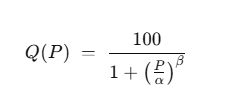

**Where**  
- alpha is the normalized price at which consumption is halved ((Q=50)),  
- beta captures the local steepness of the decline around alpha.  
**Each plot displays**:  

- Gray points: normalized observed data,  
- Black line: fitted demand curve,  
- Red dashed line and red point: alpha half-max price, (Q=50),  
- Light blue line: local slope at alpha.  
**Interpretation**
Because normalization fixes (Q_0=100), (Q_0) is no longer a free parameter and level differences are removed. Thus:  

- alpha indexes cost sensitivity on a common scale; higher alpha indicates greater willingness to pay before consumption falls to half.  
- beta quantifies how sharply consumption declines as (P) increases (larger beta → steeper drop).    

Optionally, we also report (Pmax) (vertical dotted line when included), defined as the price where elasticity equals (-1) and response output peaks.